In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
images_path = Path('data/images')
anno_path = Path('data/annotations')

In [6]:
def filelist(root, file_type):
    """get filelist from directory for given file type"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def parse_annotation(anno_path):
    """parse xml annotations and return as tabular"""
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [8]:
df = parse_annotation(anno_path)
class_dict = {'cat': 0, 'dog': 1}
df['class'] = df['class'].apply(lambda x:  class_dict[x])

In [9]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,data/images/Cats_Test0.png,233,350,0,83,29,197,142
1,data/images/Cats_Test1.png,500,500,1,128,22,240,222
2,data/images/Cats_Test10.png,500,375,1,157,56,264,116
3,data/images/Cats_Test100.png,500,375,0,142,145,206,209
4,data/images/Cats_Test1000.png,335,500,0,36,14,289,312
...,...,...,...,...,...,...,...,...
3681,data/images/Cats_Test995.png,500,375,1,98,46,179,134
3682,data/images/Cats_Test996.png,500,335,0,375,53,458,134
3683,data/images/Cats_Test997.png,500,333,0,192,88,310,212
3684,data/images/Cats_Test998.png,375,500,0,145,37,257,165


In [7]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [8]:
new_paths = []
new_bbs = []
train_path_resized = Path('data/resized')
for index, row in df.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df['new_path'] = new_paths
df['new_bb'] = new_bbs

/tmp/ipykernel_778/811859203.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


In [9]:
im = cv2.imread(str(df.values[59][0]))
bb = create_bb_array(df.values[59])
print(im.shape)

(500, 375, 3)


In [10]:
Y = create_mask(bb, im)
mask_to_bb(Y)

/tmp/ipykernel_778/811859203.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


array([166., 151., 262., 248.], dtype=float32)

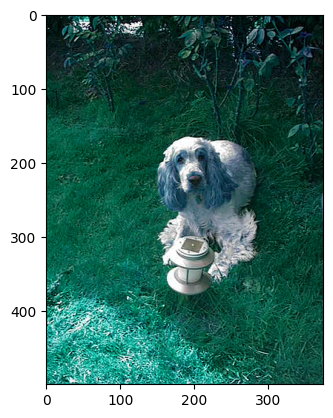

In [11]:
plt.imshow(im)

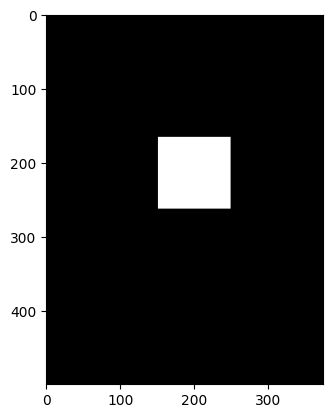

In [24]:
plt.imshow(Y, cmap='gray')

In [12]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [17]:
number = 45
im = cv2.imread(str(df.values[number][8]))
print(str(df.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#show_corner_bb(im, df.values[number][9])

data/resized/Cats_Test1038.png


In [18]:
str(df.values[59][0])

'data/images/Cats_Test1050.png'

In [19]:
str(df.values[number][8])

'data/resized/Cats_Test1038.png'

In [15]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,data/images/Cats_Test0.png,233,350,0,83,29,197,142,data/resized/Cats_Test0.png,"[24.0, 158.0, 121.0, 378.0]"
1,data/images/Cats_Test1.png,500,500,1,128,22,240,222,data/resized/Cats_Test1.png,"[13.0, 114.0, 132.0, 214.0]"
2,data/images/Cats_Test10.png,500,375,1,157,56,264,116,data/resized/Cats_Test10.png,"[44.0, 140.0, 92.0, 235.0]"
3,data/images/Cats_Test100.png,500,375,0,142,145,206,209,data/resized/Cats_Test100.png,"[116.0, 127.0, 167.0, 184.0]"
4,data/images/Cats_Test1000.png,335,500,0,36,14,289,312,data/resized/Cats_Test1000.png,"[8.0, 47.0, 186.0, 385.0]"
...,...,...,...,...,...,...,...,...,...,...
3681,data/images/Cats_Test995.png,500,375,1,98,46,179,134,data/resized/Cats_Test995.png,"[36.0, 87.0, 107.0, 159.0]"
3682,data/images/Cats_Test996.png,500,335,0,375,53,458,134,data/resized/Cats_Test996.png,"[47.0, 335.0, 119.0, 409.0]"
3683,data/images/Cats_Test997.png,500,333,0,192,88,310,212,data/resized/Cats_Test997.png,"[79.0, 171.0, 190.0, 277.0]"
3684,data/images/Cats_Test998.png,375,500,0,145,37,257,165,data/resized/Cats_Test998.png,"[22.0, 172.0, 98.0, 306.0]"


In [16]:
(str(df.values[number][8]))

'data/resized/Cats_Test1038.png'